## 7 -> Advanced Visualization

### Reading Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = pd.read_csv('../data/processed/feature_engineered.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
customer_metrics = pd.read_csv('../data/processed/customer_metrics.csv')

### 1.Customer Cohort Analysis

In [13]:
def cohort_analysis(df):
  df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

  df['MonthsSinceFirst'] = ((df['InvoiceDate'].dt.to_period('M') -
                             df['CohortMonth'])).apply(lambda x: x.n)
  
  cohort_df = df.groupby(['CohortMonth', 'MonthsSinceFirst'])['CustomerID'].nunique().unstack()

  cohort_sizes = cohort_df[0] # first column - initial state - totalcustomers for each month
  retention_rates = cohort_df.divide(cohort_sizes, axis=0) * 100 # (totalcustomers/currentcustomers) * 100

  return retention_rates

retention_rates = cohort_analysis(df)

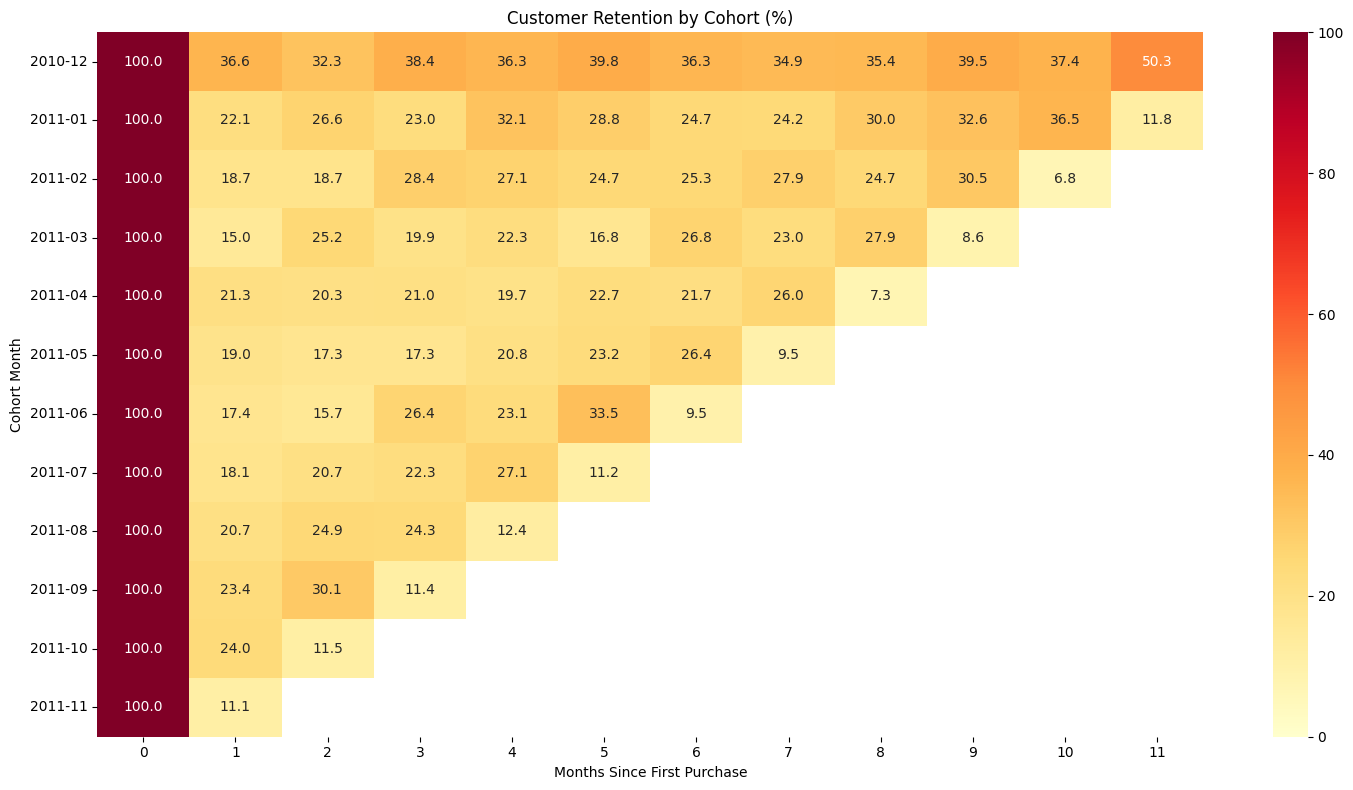

In [14]:
plt.figure(figsize=(15, 8))
sns.heatmap(retention_rates.iloc[:12, :12], 
            annot=True, #data in cell
            fmt='.1f', #round to .0
            cmap='YlOrRd', #yelloworangered
            vmin=0, #color scale
            vmax=100)
plt.title('Customer Retention by Cohort (%)')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

### 2.Customer Purchase Patterns

In [15]:
def create_radar_chart(df):
  dow_sales = df.groupby('DayOfWeek')['TotalAmount'].mean()

  categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

  fig = go.Figure()

  fig.add_trace(go.Scatterpolar(
    r=dow_sales,
    theta=categories,
    fill='toself',
    name='Average Sales'
  ))

  fig.update_layout(
    polar=dict(
      radialaxis=dict(
        visible=True,
        range=[0, dow_sales.max()]
      )
    ),
    showlegend=False,
    title='Average Sales by Day of Week'
  )
  fig.show()

create_radar_chart(df)

### 3.Customer Purchase Trajectory

In [16]:
customer_metrics['cumulative_spend'] = customer_metrics['total_spend'].cumsum()
customer_metrics['cumulative_customers'] = range(1, len(customer_metrics) + 1)

fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
  go.Scatter(x=customer_metrics.index,
             y=customer_metrics['cumulative_spend'],
             name='Cumulative Revenue'),
          secondary_y=False
)

fig.add_trace(
  go.Scatter(x=customer_metrics.index,
             y=customer_metrics['cumulative_customers'],
             name='Cumulative Customers'),
          secondary_y=True
)

fig.update_layout(
  title='Customer Growth vs Revenue Growth',
  xaxis_title='Customer Index',
  yaxis_title='Cumulative Revenue',
  yaxis2_title='Cumulative Customers'
)

fig.show()